In [ ]:
pip install -U keras.tuner

     |████████████████████████████████| 71kB 4.4MB/s 
  Created wheel for keras.tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=5c1017ed2847665d0ef539f0de066295952c79194d4564fa04ada1c90dff6b0b
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=412985a913e14b40624a23d8a1db7e337a91dd8bfd000ab263e15eddc65ac570
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras.tuner terminaltables


In [ ]:
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

##Load Data

In [ ]:
#Creating the training and testing sets 
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

#Creating the Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1, shuffle = True)

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (40000, 32, 32, 3)
X_val shape:  (10000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)


##Normalizing the Data

In [ ]:
#Normalising the inputs to range between 0 and 1 by dividing by 255
#Since it is very common to use 32 bit precision when training a neural network, the training data 
#will be converted to float32 type, might as well convert it before dividing by 255

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

##One-Hot Encoding the Labels

In [ ]:
#One Hot Encoding the Labels
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

In [ ]:
print(X_train.shape)

(40000, 32, 32, 3)


##Custom CNN

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def custom_cnn_model(hp):
  model = tf.keras.models.Sequential()

  #1st CONVOLUTIONAL LAYER
  #Hyperparameters - a) Number of Filters used   b) Size of the filter
  model.add(Conv2D(filters = hp.Int(name = 'conv_1_filter', min_value = 32, max_value = 128, step = 20), kernel_size = hp.Choice(name = 'conv_1_kernel_size', values = [2,3]), activation = "relu", input_shape = (32,32,3)))

  #1st POOLING LAYER    
  #Hyperparamters - a) Dropout Rate                         
  model.add(MaxPooling2D(pool_size = (2,2), strides = 2)),
  model.add(Dropout(rate=hp.Float(name = 'dropout_1', min_value = 0.2, max_value = 0.5, step = 0.1))),
  model.add(BatchNormalization()),

  #2nd CONVOLUTIONAL LAYER
  #Hyperparameters - a) Number of Filters used   b) Size of the filter
  model.add(Conv2D(filters = hp.Int(name = 'conv_3_filter', min_value = 32, max_value = 128, step = 20), kernel_size = hp.Choice(name = 'conv_3_kernel_size', values = [2,3]), activation = "relu")),

  #FLATTEN                             
  model.add(Flatten())

  #1st DENSE LAYER
  #Hyperparameters - a) Number of Neurons in the Dense Layer   b) Dropout Rate
  model.add(Dense(units = hp.Int(name = 'fc_1_units', min_value = 32, max_value = 128, step = 20), activation = "relu"))
  model.add(Dropout(rate=hp.Float(name = 'dropout_fc1', min_value = 0.2, max_value = 0.5, step = 0.1)))
  model.add(BatchNormalization())
                               
  #2nd DENSE LAYER 
  #Hyperparameters - a) Number of Neurons in the Dense Layer   b) Dropout Rate                            
  model.add(Dense(units = hp.Int(name='fc_2_units', min_value = 32, max_value = 128, step = 20), activation = "relu"))
  model.add(Dropout(rate=hp.Float(name='dropout_fc2', min_value = 0.2, max_value = 0.5, step = 0.1)))
  model.add(BatchNormalization())                        
                               
  #OUTPUT LAYER
  model.add(Dense(units = 10, activation = "softmax"))
  

  #Compiling the Model
  #Hyperparameter - a) Learning Rate
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice(name = 'learning_rate', values=[0.01,0.001])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

#Therefore all in all there are 10 hyperparameters that we are observing/monitoring

In [ ]:
#creating an instance
#only going to try it 5 times and each time it tries with 3 different models
tuner = RandomSearch(
    custom_cnn_model, objective = "val_accuracy", max_trials = 5, executions_per_trial = 3,
    directory = "my_dir", project_name = "cifar10_cnn" #saves teh weights
)

In [ ]:
tuner.search_space_summary()
#The search space size = 10 as there are 10 hyperparameters that we are observing

Search space summary
Default search space size: 10
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 20, 'sampling': None}
conv_1_kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 20, 'sampling': None}
conv_3_kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
fc_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 20, 'sampling': None}
dropout_fc1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
fc_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 20, 'sampling': None}
dropout_fc2 (Float)
{'default': 0.2, 

In [ ]:
tuner.search(X_train, y_train, epochs = 5, validation_data = (X_val, y_val))

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/cifar10_cnn
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 52
conv_1_kernel_size: 2
dropout_1: 0.30000000000000004
conv_3_filter: 92
conv_3_kernel_size: 2
fc_1_units: 72
dropout_fc1: 0.2
fc_2_units: 92
dropout_fc2: 0.4000000000000001
learning_rate: 0.001
Score: 0.6434666713078817
Trial summary
Hyperparameters:
conv_1_filter: 72
conv_1_kernel_size: 2
dropout_1: 0.2
conv_3_filter: 72
conv_3_kernel_size: 2
fc_1_units: 112
dropout_fc1: 0.4000000000000001
fc_2_units: 72
dropout_fc2: 0.30000000000000004
learning_rate: 0.001
Score: 0.6158000032107035
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel_size: 3
dropout_1: 0.2
conv_3_filter: 92
conv_3_kernel_size: 2
fc_1_units: 52
dropout_fc1: 0.30000000000000004
fc_2_units: 92
dropout_fc2: 0.2
learning_rate: 0.01
Score: 0.5822333296140035
Trial summary
Hyperparameters:
conv_1_filter: 52
conv_1_kernel_size: 2
dropout_1: 0.2
conv_3_

In [ ]:
model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 52)        676       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 52)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 52)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 52)        208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 92)        19228     
_________________________________________________________________
flatten (Flatten)            (None, 18032)             0         
_________________________________________________________________
dense (Dense)                (None, 72)                1

In [ ]:
#Callbacks
filepath_a ="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

my_callbacks = [
                
                #Will monitor the validation loss and training loop will check at end of every epoch 
                #whether the loss is no longer decreasing, will end early if there has been no loss change
                #for 5 epochs
                
                tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = "max", patience = 5),

                #To save the Weights at some interval
                tf.keras.callbacks.ModelCheckpoint(monitor = "val_loss", mode = "min", filepath=filepath_a, save_best_only=True)

                #Learning Rate Scheduler - for variable learning rate
                #tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
]

In [ ]:
hist_1 = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 50, callbacks = my_callbacks, batch_size = 64)

Epoch 1/50
625/625 [==============================] - 83s 131ms/step - loss: 2.0336 - accuracy: 0.2916 - val_loss: 1.3798 - val_accuracy: 0.5193
Epoch 2/50
625/625 [==============================] - 84s 134ms/step - loss: 1.3719 - accuracy: 0.5091 - val_loss: 1.3365 - val_accuracy: 0.5363
Epoch 3/50
625/625 [==============================] - 81s 129ms/step - loss: 1.2074 - accuracy: 0.5760 - val_loss: 1.0312 - val_accuracy: 0.6377
Epoch 4/50
625/625 [==============================] - 80s 128ms/step - loss: 1.1085 - accuracy: 0.6136 - val_loss: 0.9888 - val_accuracy: 0.6471
Epoch 5/50
625/625 [==============================] - 82s 131ms/step - loss: 1.0307 - accuracy: 0.6389 - val_loss: 1.1023 - val_accuracy: 0.6289
Epoch 6/50
625/625 [==============================] - 84s 135ms/step - loss: 0.9541 - accuracy: 0.6684 - val_loss: 0.9714 - val_accuracy: 0.6557
Epoch 7/50
625/625 [==============================] - 81s 129ms/step - loss: 0.9021 - accuracy: 0.6900 - val_loss: 0.9856 - val_ac

29 epochs with batch size 64

In [ ]:
model.save('final_model.h5')

#Evaluating Model

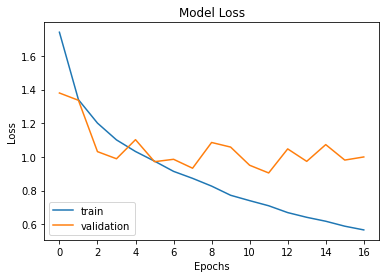

In [ ]:
#Plotting the Loss
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

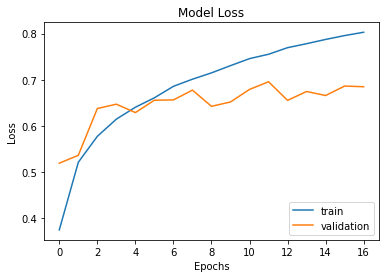

In [ ]:
#Plotting the Accuracy
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
print("Inital Model")
inital_accuracy = 0.6434666713078817
print("Max Accuracy: ", inital_accuracy)
print("\n")
print("After Hyperparameter Tuning")
print("Training Set Metrics")
print("Max Accuracy: ", max(hist_1.history['accuracy']))
print("Min Loss: ", min(hist_1.history['loss']))
print("\n")
print("Validation Set Metrics")
print("Max Accuracy: ", max(hist_1.history['val_accuracy']))
print("Min Loss: ", min(hist_1.history['val_loss']))

Inital Model
Max Accuracy:  0.6434666713078817


After Hyperparameter Tuning
Training Set Metrics
Max Accuracy:  0.8029749989509583
Min Loss:  0.5656818151473999


Validation Set Metrics
Max Accuracy:  0.6956999897956848
Min Loss:  0.9044349789619446


In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions

array([[6.4218184e-05, 1.7634840e-05, 1.5302432e-03, ..., 6.8270776e-04,
        2.0141040e-03, 6.1913117e-05],
       [1.1415290e-02, 1.0703349e-03, 3.6050773e-05, ..., 2.4324294e-07,
        9.8745930e-01, 4.2778684e-06],
       [7.6198131e-02, 2.4427561e-02, 7.5010641e-04, ..., 9.4719295e-04,
        8.8692880e-01, 8.0446620e-03],
       ...,
       [8.5581320e-05, 8.0823438e-06, 2.1812260e-02, ..., 2.3433702e-02,
        1.9069923e-04, 1.4821476e-04],
       [2.6231210e-03, 9.4276285e-03, 8.1632398e-02, ..., 9.9789478e-02,
        5.2797497e-04, 3.6909862e-04],
       [4.8764099e-07, 7.9103195e-09, 1.7699353e-04, ..., 9.8750383e-01,
        4.0481506e-08, 4.9129621e-08]], dtype=float32)

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
y_classes = [np.argmax(element) for element in predictions]
y_classes[:5]

[5, 8, 8, 0, 6]

In [ ]:
y_classes_test = [np.argmax(element) for element in y_test]
y_classes_test[:5]

[3, 8, 8, 0, 6]

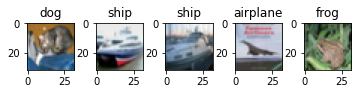

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
    # define subplot
    plt.subplot(4,5, i+1)
    plt.title(classes[y_classes[i]])
    # plot raw pixel data
    plt.imshow(X_test[i])
# show the figure
plt.show()

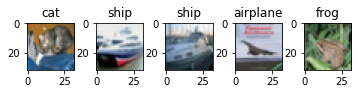

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
    # define subplot
    plt.subplot(4,5, i+1)
    plt.title(classes[y_classes_test[i]])
    # plot raw pixel data
    plt.imshow(X_test[i])
# show the figure
plt.show()

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
preds = np.argmax(predictions, axis=1)
y_test_rev = np.argmax(y_test, axis=1)

In [ ]:
from sklearn import metrics
print("Test Accuracy = ", metrics.accuracy_score(y_test_rev, preds))

Test Accuracy =  0.6871


In [ ]:
import shutil, sys 
shutil.move("/content/my_dir", "/content/drive/MyDrive/Colab Notebooks") 

'/content/drive/MyDrive/Colab Notebooks/my_dir'

In [ ]:
shutil.move("/content/final_model.h5", "/content/drive/MyDrive/Colab Notebooks") 
shutil.move("/content/weights-improvement-01-0.52.hdf5", "/content/drive/MyDrive/Colab Notebooks") 
shutil.move("/content/weights-improvement-02-0.54.hdf5", "/content/drive/MyDrive/Colab Notebooks")
shutil.move("/content/weights-improvement-03-0.64.hdf5", "/content/drive/MyDrive/Colab Notebooks")
shutil.move("/content/weights-improvement-04-0.65.hdf5", "/content/drive/MyDrive/Colab Notebooks")
shutil.move("/content/weights-improvement-06-0.66.hdf5", "/content/drive/MyDrive/Colab Notebooks")
shutil.move("/content/weights-improvement-08-0.68.hdf5", "/content/drive/MyDrive/Colab Notebooks")
shutil.move("/content/weights-improvement-12-0.70.hdf5", "/content/drive/MyDrive/Colab Notebooks")

'/content/drive/MyDrive/Colab Notebooks/weights-improvement-12-0.70.hdf5'